In [1]:
import pandas as pd
import random
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as sco

In [81]:
esg=pd.read_excel(r'C:\Users\niroo\Desktop\Jupyter\Projets\Ethique\ESG.xlsx')
dataset=pd.read_excel(r'C:\Users\niroo\Desktop\Jupyter\Projets\Ethique\S&P500.xlsx',index_col=0)

In [130]:
class ESG_filter:
    
    def __init__(self,esg_data):
        self.esg_data=esg_data
        
    def plot_sectors(self):
        stats = self.esg_data.groupby(by='Sector', as_index=False).mean()
        stats=stats.sort_values('ESG score',ascending=False)
        average = stats['ESG score'].mean(numeric_only=None)
        colors = ['mediumspringgreen' if (stat > average) else 'darkcyan' for stat in stats['ESG score']]
        plt.figure(figsize=(15,20))
        ax = sns.barplot(x=stats['ESG score'], y=stats['Sector'],palette=colors, ci=None)
        
    def order_data(self):
        ordered_data=self.esg_data.sort_values(by='ESG score')
        best_companies=ordered_data[:len(ordered_data)//2]
        worst_companies=ordered_data[len(ordered_data)//2:]
        
        return best_companies,worst_companies
    
    def sectors(self):
        stock_sectors=dict()
        sectors=self.esg_data['Sector'].unique()
        for sector in sectors:
            stock_sectors[sector]=self.esg_data.loc[self.esg_data['Sector']==sector]
        return stock_sectors
    

In [131]:
class Randomize:
    def __init__(self,assets,num_assets):
        self.assets=assets
        self.num_assets=num_assets
        
    def random_assets(self):
        unique_assets=self.assets['Stock'].unique()
        random_assets=np.random.choice(unique_assets,self.num_assets,replace=False)
        return random_assets

In [132]:
class Portfolio:
    
    def __init__(self,data):
        self.data=data
        self.max_iterations=1000
    
    def random_weight(self):
        weight=np.random.random(len(self.data.columns))
        weight /= weight.sum()
        return weight
    
    def variance(self,weight):
        variance=np.dot(weight.T,np.dot(self.data.cov()*252,weight))
        return variance
    
    def performance(self,weight):
        perfan=np.sum(self.data.mean()*weight)*252
        return perfan
    
    def Sharpe_ratio(self,weight):
        R=self.performance(weight)
        V=self.variance(weight)
        SR=R/V
        return -1*SR
    
    def fit(self):
        
        portfolio_variance=[]
        portfolio_returns=[]
        sharpe_ratio=[]
        weights=[]
        
        for i in range(self.max_iterations):
            weight=self.random_weight()
            var=self.variance(weight)
            returns=self.performance(weight)
            SR= returns/var
            portfolio_variance.append(var)
            portfolio_returns.append(returns)
            sharpe_ratio.append(SR)
            weights.append(weight)
               
        return portfolio_returns,portfolio_variance,sharpe_ratio,weights
    
    
    def sum_equal_one(self, weight):
        return np.sum(weight) - 1   
    
    def optimize(self):
        n_assets = len(self.data.columns)
        weight = np.array([1 / n_assets] * n_assets)
        bounds = tuple((0, 1) for _ in range(n_assets))
        constraints = [{'type': 'eq', 'fun': self.sum_equal_one}]
        optimum_weights = sco.minimize(self.variance, weight, method='SLSQP', bounds=bounds, constraints=constraints)
        #optimum_SR = sco.minimize(self.Sharpe_ratio, weight, method='SLSQP', bounds=bounds, constraints=constraints)
        
        return optimum_weights.x
    
    
    def VaR(self):
        
        optimum_weight=self.optimize()
        portfolio_return=(optimum_weight*self.data).sum(axis=1)
        
        return np.percentile(portfolio_return,5,interpolation='lower')
    
    def plot_VaR(self):
        
        optimum_weight=self.optimize()
        portfolio_return=(optimum_weight*self.data).sum(axis=1)
        VaR=self.VaR()
        hist, bins, _ = plt.hist(portfolio_return, bins=50, density=True,color='lightskyblue',edgecolor='white')
        mask = (bins[:-1] < VaR)
        for i in range(len(mask)):
            if mask[i]:
                plt.bar(bins[i], hist[i], width=bins[i+1]-bins[i],alpha=0.5, color='red',edgecolor='white')
        plt.text(VaR-0.015, max(hist)*0.9, 'VaR at '+str(round(VaR,3))+'%', ha='center', va='center', color='r', fontsize=10)
        plt.ylabel('Frequency')
        plt.title('Value At Risk 95%')
        plt.show()
        
        
    def plot_portfolio(self,cmap=None):
        
        if (cmap==None):
            self.cmap='viridis'
        else:
            self.cmap=cmap
            
        sample=self.fit()
        
        X=sample[1]
        Y=sample[0]
        c=sample[2]
        
        optimum_weights=self.optimize()
        
        minimum_variance=self.variance(optimum_weights)
        optimum_returns=self.performance(optimum_weights)

        plt.scatter(X,Y,c=c, cmap=self.cmap)
        plt.plot(minimum_variance,optimum_returns,c='red',marker='.',markersize=15)
        plt.title('Frontiere efficiente')
        plt.xlabel('Variance du portefeuille')
        plt.ylabel('Esperance du portefeuille')
        plt.show()
        
    

In [134]:
stock_price=dataset[:-1]
stock_price=stock_price.dropna(axis='columns')
returns=stock_price.pct_change()

In [93]:
esg_data=ESG_filter(esg)
best=esg_data.order_data()[0]
worst=esg_data.order_data()[1]

In [94]:
best_filter=ESG_filter(best[:100])
worst_filter=ESG_filter(worst[len(worst)-100:])

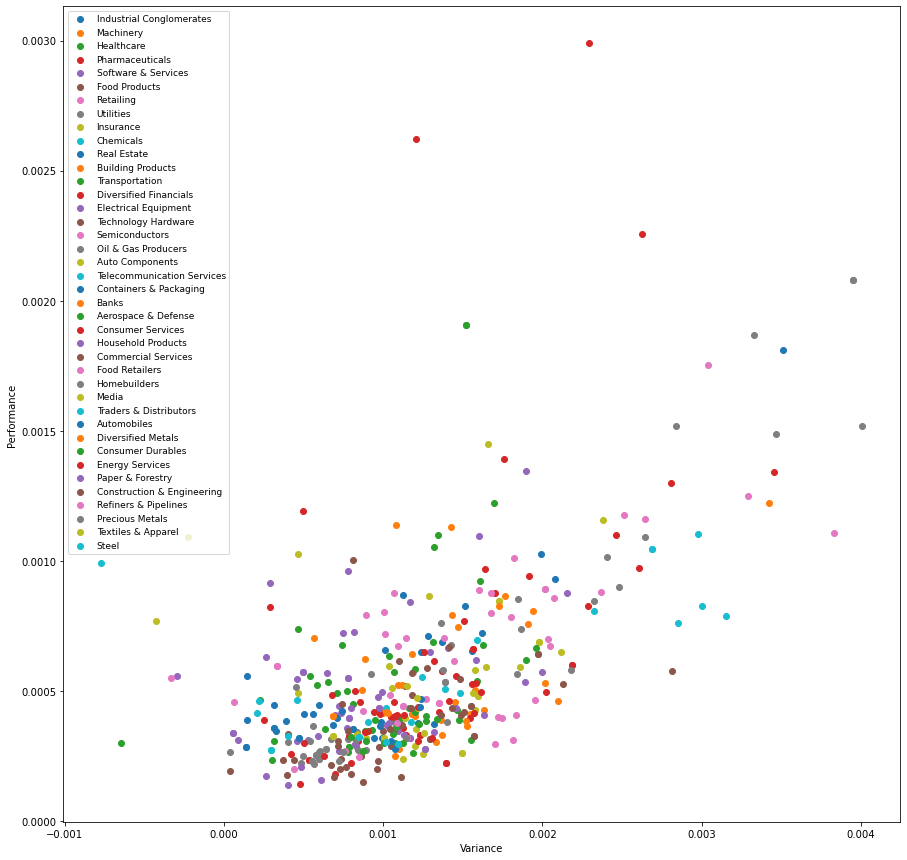

In [101]:
dico={}

for sectors in esg_data.sectors():
    list_of_stock=[]
    for stock in esg_data.sectors()[sectors]['Stock']:
        list_of_stock.append(stock)
        var=returns[list_of_stock].var()
        mean=returns[list_of_stock].mean()
        dico[sectors]=[mean,var]
plt.figure(figsize=(15, 15))

for key in dico:
    plt.scatter(dico[key][0],dico[key][1],cmap=key)

plt.ylabel('Performance')
plt.xlabel('Variance')
plt.legend(dico.keys(),fontsize = 9)
plt.show()

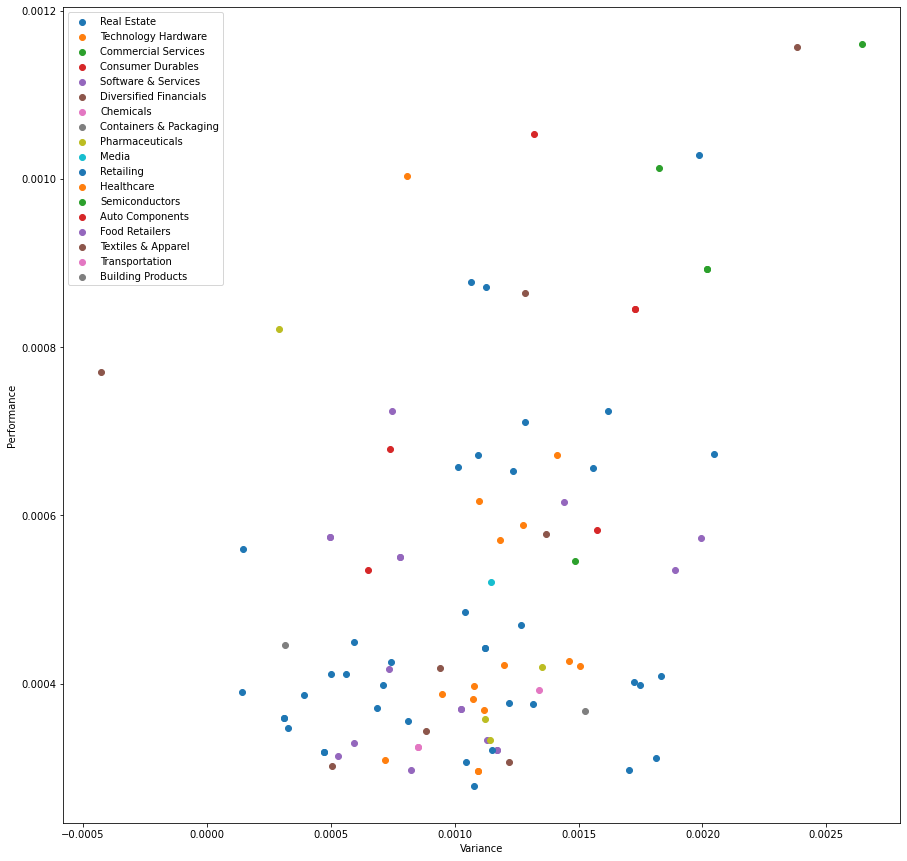

In [103]:
best_esg={}

for sectors in best_filter.sectors():
    list_of_stock=[]
    for stock in best_filter.sectors()[sectors]['Stock']:
        list_of_stock.append(stock)
        var=returns[list_of_stock].var()
        mean=returns[list_of_stock].mean()
        best_esg[sectors]=[mean,var]

plt.figure(figsize=(15, 15))

        
for key in best_esg:
    plt.scatter(best_esg[key][0],best_esg[key][1],cmap=key)

plt.ylabel('Performance')
plt.xlabel('Variance')
plt.legend(best_esg.keys())
plt.show()

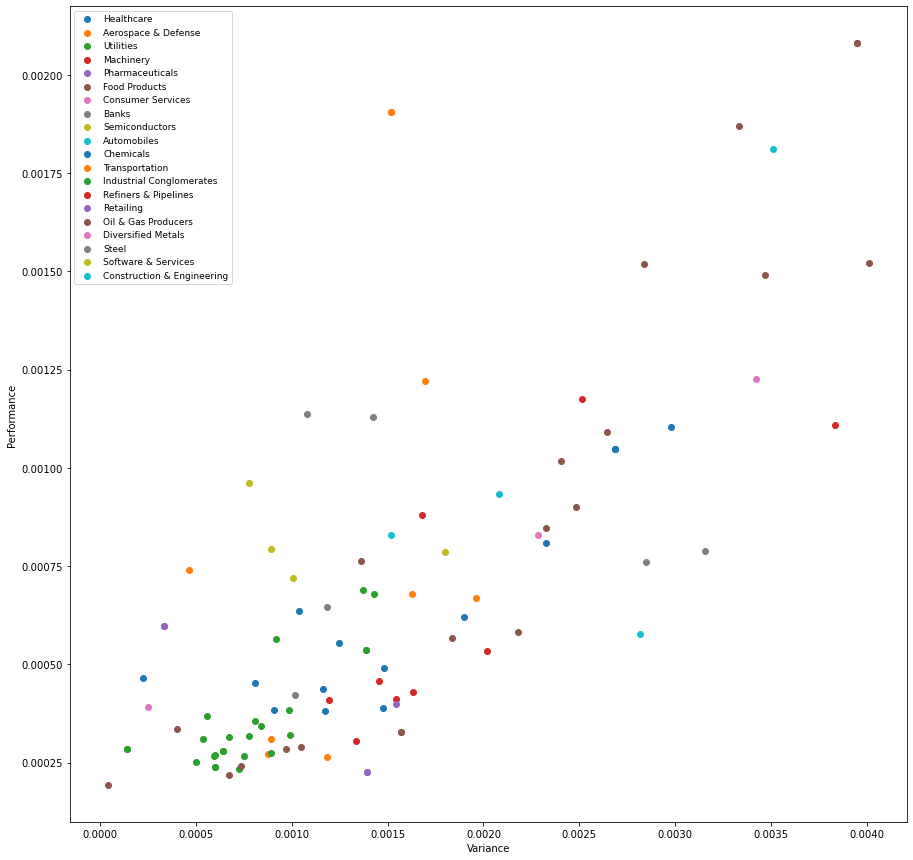

In [104]:
worst_esg={}

for sectors in worst_filter.sectors():
    list_of_stock=[]
    for stock in worst_filter.sectors()[sectors]['Stock']:
        list_of_stock.append(stock)
        var=returns[list_of_stock].var()
        mean=returns[list_of_stock].mean()
        worst_esg[sectors]=[mean,var]
        
        
plt.figure(figsize=(15, 15))

for key in worst_esg:
    plt.scatter(worst_esg[key][0],worst_esg[key][1],cmap=key)

plt.ylabel('Performance')
plt.xlabel('Variance')
plt.legend(worst_esg.keys(),fontsize = 9)
plt.show()

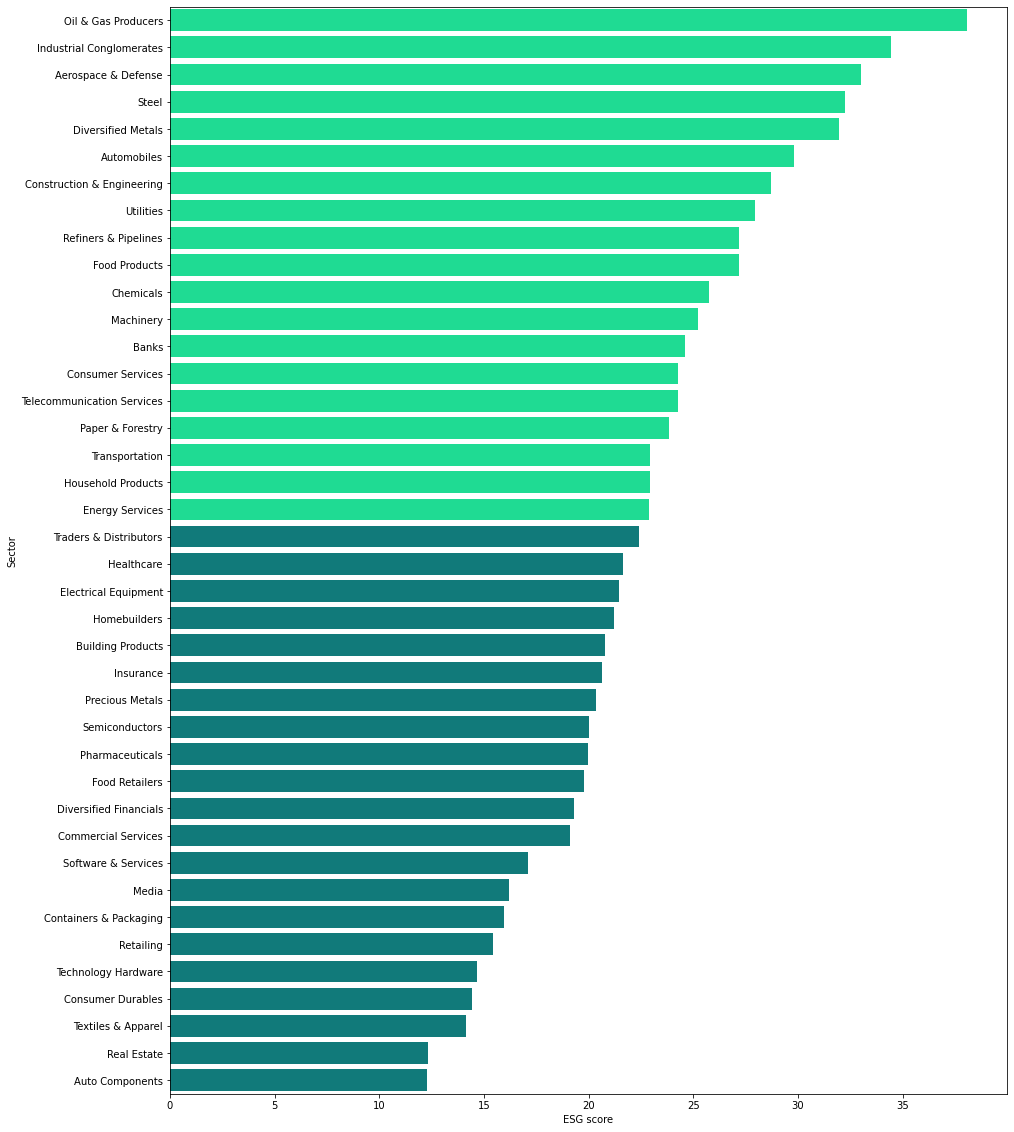

In [105]:
esg_data.plot_sectors()

In [144]:
best50=best[:50]
worst50=worst[len(worst)-50:]

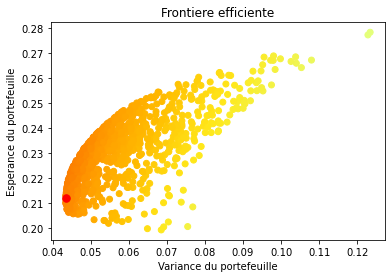

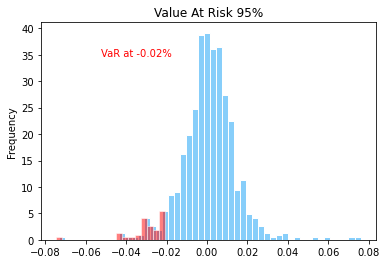

In [146]:
worst_random=Randomize(worst,3).random_assets()
portfolio=Portfolio(returns[worst_random])
portfolio.plot_portfolio('Wistia')
portfolio.plot_VaR()

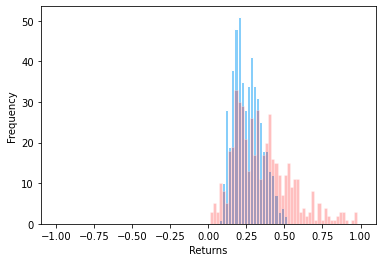

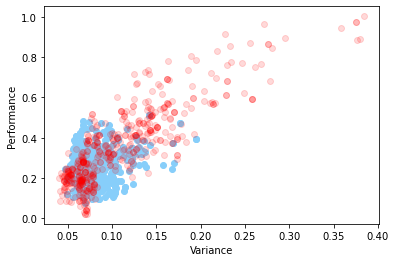

In [276]:
high_score_performance=[]
low_score_performance=[]
high_score_variance=[]
low_score_variance=[]
n=2

for i in range(500):
    best_random=Randomize(best50,n).random_assets()
    worst_random=Randomize(worst50,n).random_assets()
    best_dataset=Dataset(dataset,best_random).returns()
    worst_dataset=Dataset(dataset,worst_random).returns()

    best_portfolio=Portfolio(returns[best_random])
    worst_portfolio=Portfolio(returns[worst_random])
    performance_high=best_portfolio.performance(best_portfolio.optimize())
    performance_low=worst_portfolio.performance(worst_portfolio.optimize())
    variance_high=best_portfolio.variance(best_portfolio.optimize())
    variance_low=worst_portfolio.variance(worst_portfolio.optimize())
    
    high_score_performance.append(performance_high)
    low_score_performance.append(performance_low)
    high_score_variance.append(variance_high)
    low_score_variance.append(variance_low)

bins=np.linspace(-1, 1, 100)
plt.hist(high_score_performance,bins,alpha=1,color='lightskyblue',edgecolor='white')
plt.hist(low_score_performance,bins,alpha=0.25,color='red',edgecolor='white')
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.show()

plt.scatter(high_score_variance,high_score_performance,color='lightskyblue')
plt.scatter(low_score_variance,low_score_performance,alpha=0.15,color='red')
plt.ylabel('Performance')
plt.xlabel('Variance')
plt.show()

In [279]:
range_assets=[n for n in range(0,10,5)]
range_assets[0]=1
range_assets

[1, 5]

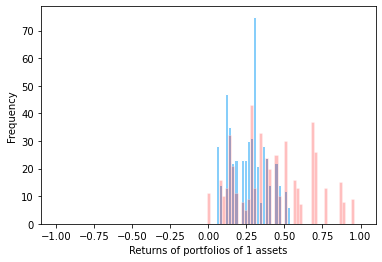

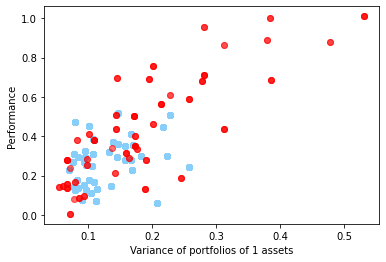

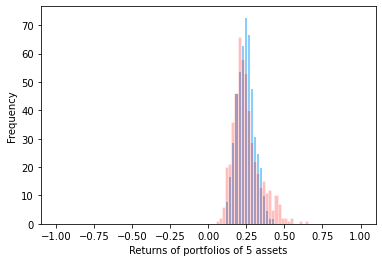

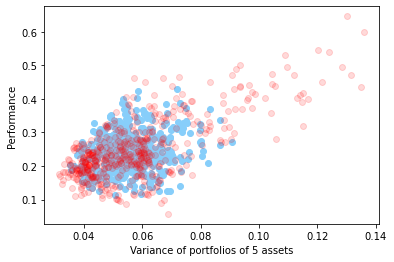

In [280]:
for n in range_assets:

    high_score_performance=[]
    low_score_performance=[]
    high_score_variance=[]
    low_score_variance=[]

    for i in range(500):
        best_random=Randomize(best50,n).random_assets()
        worst_random=Randomize(worst50,n).random_assets()

        best_portfolio=Portfolio(returns[best_random])
        worst_portfolio=Portfolio(returns[worst_random])
        performance_high=best_portfolio.performance(best_portfolio.optimize())
        performance_low=worst_portfolio.performance(worst_portfolio.optimize())
        variance_high=best_portfolio.variance(best_portfolio.optimize())
        variance_low=worst_portfolio.variance(worst_portfolio.optimize())

        high_score_performance.append(performance_high)
        low_score_performance.append(performance_low)
        high_score_variance.append(variance_high)
        low_score_variance.append(variance_low)

    bins=np.linspace(-1, 1, 100)
    plt.hist(high_score_performance,bins,alpha=1,color='lightskyblue',edgecolor='white')
    plt.hist(low_score_performance,bins,alpha=0.25,color='red',edgecolor='white')
    plt.xlabel('Returns of portfolios of '+str(n)+' assets')
    plt.ylabel('Frequency')
    plt.show()

    plt.scatter(high_score_variance,high_score_performance,color='lightskyblue')
    plt.scatter(low_score_variance,low_score_performance,alpha=0.15,color='red')
    plt.ylabel('Performance')
    plt.xlabel('Variance of portfolios of '+str(n)+' assets')
    plt.show()